# Setup

In [ ]:
!pip install git+https://github.com/openai/jukebox.git

  Cloning https://github.com/openai/jukebox.git to /tmp/pip-req-build-r2rldbkq
  Running command git clone -q https://github.com/openai/jukebox.git /tmp/pip-req-build-r2rldbkq
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 245kB 12.1MB/s 
     |████████████████████████████████| 3.6MB 16.7MB/s 
     |████████████████████████████████| 1.6MB 43.2MB/s 
     |████████████████████████████████| 1.4MB 48.3MB/s 
     |████████████████████████████████| 20.2MB 1.6MB/s 
  Created wheel for jukebox: filename=jukebox-1.0-cp37-none-any.whl size=197908 sha256=aed745a92cb9def3f4eec39a8be52f5103169b905b14ac9c6aa8ea5794b8551d
  Stored in directory: /tmp/pip-ephem-wheel-cache-envfbtzv/wheels/bd/b6/f9/ad38a67dd989a522bbe6677e95efbc4607cdcf71e7249485fe
  Created wheel for fire: filename=fire-0.1.3-py2.py3-none-any.whl size=49705 sha256=d4a91ed62a23e2885964edcd8c72e979f866e60c90eb20c1ceeb5f02f04b24dc
  Stored in directory: /root/.cache/pip/wheels/2a/1a/4d/6b3037

IMPORTANT NOTE ON SYSTEM REQUIREMENTS:

If you are connecting to a hosted runtime, make sure it has a P100 GPU (optionally run !nvidia-smi to confirm). Go to Edit>Notebook Settings to set this.

CoLab may first assign you a lower memory machine if you are using a hosted runtime.  If so, the first time you try to load the 5B model, it will run out of memory, and then you'll be prompted to restart with more memory (then return to the top of this CoLab).  If you continue to have memory issues after this (or run into issues on your own home setup), switch to the 1B model.

If you are using a local GPU, we recommend V100 or P100 with 16GB GPU memory for best performance. For GPU’s with less memory, we recommend using the 1B model and a smaller batch size throughout.  



In [ ]:
!nvidia-smi

Wed Mar 24 11:54:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import jukebox
import torch as t
import librosa
import os
from IPython.display import Audio
from jukebox.make_models import make_vqvae, make_prior, MODELS, make_model
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.sample import sample_single_window, _sample, \
                           sample_partial_window, upsample
from jukebox.utils.dist_utils import setup_dist_from_mpi
from jukebox.utils.torch_utils import empty_cache
rank, local_rank, device = setup_dist_from_mpi()

Using cuda True


# Sample from the 5B or 1B Lyrics Model


Jukebox support different sample techniques:


*   Re-rerenditions: Inputs are arbitrary genre, interpret and lyrics from the training set
*   Completitions: Inputs are 12 sec of a song as well as the belonging songs genre, interpret and lyrics


In [ ]:
if not t.cuda.is_available():
  raise EnvironmentError("Without cuda, you will wait forever")

In [ ]:
model = "5b_lyrics"    
hps = Hyperparams()
hps.sr = 44100
hps.n_samples = 3 if model=='5b_lyrics' else 8
hps.name = 'samples'
chunk_size = 16 if model=="5b_lyrics" else 32
max_batch_size = 3 if model=="5b_lyrics" else 16
hps.levels = 3
hps.hop_fraction = [.5,.5,.125]

vqvae, *priors = MODELS[model]
vqvae = make_vqvae(setup_hparams(vqvae, dict(sample_length = 1048576)), device)
top_prior = make_prior(setup_hparams(priors[-1], dict()), vqvae, device)



Running  wget -O /root/.cache/jukebox/models/5b/vqvae.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b/vqvae.pth.tar
Restored from /root/.cache/jukebox/models/5b/vqvae.pth.tar
0: Loading vqvae in eval mode
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_artist_ids.txt
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_genre_ids.txt
Level:2, Cond downsample:None, Raw to tokens:128, Sample length:1048576
0: Converting to fp16 params
Running  wget -O /root/.cache/jukebox/models/5b_lyrics/prior_level_2.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b_lyrics/prior_level_2.pth.tar
Restored from /root/.cache/jukebox/models/5b_lyrics/prior_level_2.pth.tar
0: Loading prior in eval mode


## Exploring the model
As you can see below, we can pick between three different models. They have a parameter size of either 1 or 5 billion and are with or without lyrics conditioning. Be aware that only the priors differ for each model. They all share the same upsamplers and VQ-VAEs. 

The modules of the model have the following sizes:


*   5b_prior: 11GB
*   VQ-VAE: 7MB
*   Upsamplers: 2.2GB




In [ ]:
MODELS

{'1b_lyrics': ('vqvae',
  'upsampler_level_0',
  'upsampler_level_1',
  'prior_1b_lyrics'),
 '5b': ('vqvae', 'upsampler_level_0', 'upsampler_level_1', 'prior_5b'),
 '5b_lyrics': ('vqvae',
  'upsampler_level_0',
  'upsampler_level_1',
  'prior_5b_lyrics')}

### VQ-VAE
We will now look have a closer look at each module of Jukebox, starting with the VQ-VAE. VQ-VAE converts the raw audio into discrete tokens. The module contains all three encoders and decoders for the different levels of abstrations. There are using the residual, dilated convolution of wavenet. Since VQ-VAE is convolutional it can be used for arbitrary audio lengths. 

Below you can see the architecture of the VQ-VAE


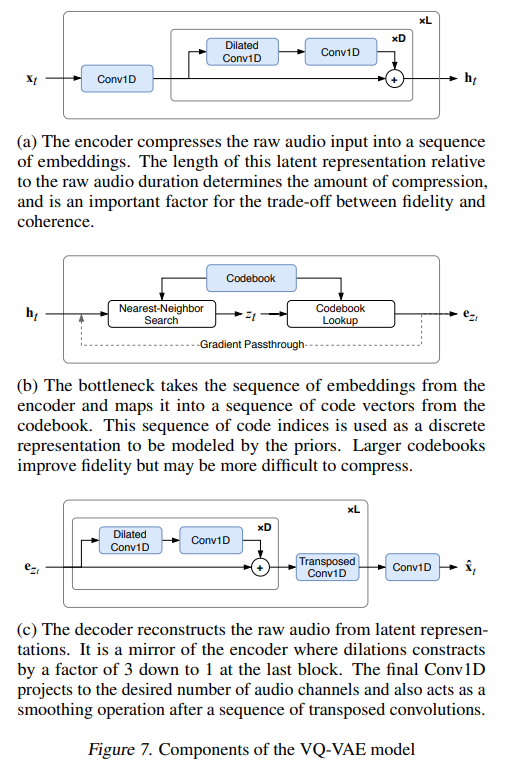

In [ ]:
vqvae

VQVAE(
  (encoders): ModuleList(
    (0): Encoder(
      (level_blocks): ModuleList(
        (0): EncoderConvBlock(
          (model): Sequential(
            (0): Sequential(
              (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,))
              (1): Resnet1D(
                (model): Sequential(
                  (0): ResConv1DBlock(
                    (model): Sequential(
                      (0): ReLU()
                      (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
                      (2): ReLU()
                      (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
                    )
                  )
                  (1): ResConv1DBlock(
                    (model): Sequential(
                      (0): ReLU()
                      (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
                      (2): ReLU()
                      (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
       

### Top prior
Next, there is the top prior. The top prior generates **a sequence of tokens**. It is **conditioned by embeddings** of the music genre, the interpret and timing signals such as the total length of the song, start time of a particular sample and the fraction of the song that has elapsed. It consists of 72 Transformer Layers. After each step it outputs a distribution over **2127 tokens**.

The top prior as well as the upsampler module are sparse Transformer. What makes these Transformers sparse is their attention mechanism: all states are arranged to a rectangle and the attention can only access the bright grey states (see picture below section a)). This significantly reduces the computational work and overall complexity of the attention mechanism making it better scalable to larger sequence lenghts - 8096 in this case. Altough the attention mechanism now does not has no direct acces to all previous states, it still has indirect acces to all precious states of former layers (as illustrated by section b) of the illustration). Of course, this indirect access does not work as good as a direct global access.

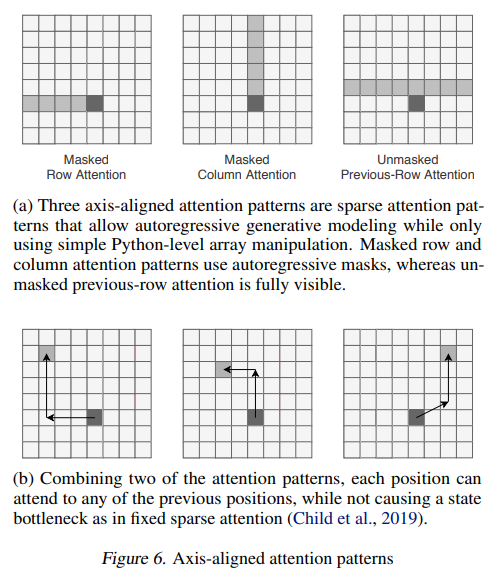

In [ ]:
top_prior

SimplePrior(
  (y_emb): LabelConditioner(
    (bow_genre_emb): SimpleEmbedding(
      (emb): Embedding(120, 4800)
    )
    (artist_emb): SimpleEmbedding(
      (emb): Embedding(4111, 4800)
    )
    (total_length_emb): RangeEmbedding(
      (emb): Embedding(128, 4800)
    )
    (absolute_pos_emb): RangeEmbedding(
      (emb): Embedding(128, 4800)
    )
    (relative_pos_emb): RangeEmbedding(
      (emb): Embedding(128, 4800)
    )
  )
  (prime_prior): ConditionalAutoregressive2D(
    (x_emb): Embedding(80, 1280)
    (x_emb_dropout): Dropout(p=0.0, inplace=False)
    (pos_emb): PositionEmbedding()
    (pos_emb_dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (_attn_mods): ModuleList(
        (0): ResAttnBlock(
          (attn): FactoredAttention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
          )
          (ln_0): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Conv1D()
            (c_p

### Upsamplers
The upsamplers use the **tokens of the upper level as conditioning information**. The tokens of the upper level are feed into an wavenet, the output of the followed strided convolutions is used as extra positional information. The conditioning is only applied to the codes that correspond to the same raw audio segment. Like the Prior it is also conditioned by the embeddings.

## Sample

Specify your choice of artist, genre, lyrics, and length of musical sample. 

In [ ]:
sample_length_in_seconds = 60          # Full length of musical sample to generate - we find songs in the 1 to 4 minute
                                       # range work well, with generation time proportional to sample length.  
                                       # This total length affects how quickly the model 
                                       # progresses through lyrics (model also generates differently
                                       # depending on if it thinks it's in the beginning, middle, or end of sample)

hps.sample_length = (int(sample_length_in_seconds*hps.sr)//top_prior.raw_to_tokens)*top_prior.raw_to_tokens
assert hps.sample_length >= top_prior.n_ctx*top_prior.raw_to_tokens, f'Please choose a larger sampling rate'

In [ ]:
metas = [dict(artist = "Zac Brown Band",
            genre = "Country",
            total_length = hps.sample_length,
            offset = 0,
            lyrics = """I met a traveller from an antique land,
            Who said—“Two vast and trunkless legs of stone
            Stand in the desert. . . . Near them, on the sand,
            Half sunk a shattered visage lies, whose frown,
            And wrinkled lip, and sneer of cold command,
            Tell that its sculptor well those passions read
            Which yet survive, stamped on these lifeless things,
            The hand that mocked them, and the heart that fed;
            And on the pedestal, these words appear:
            My name is Ozymandias, King of Kings;
            Look on my Works, ye Mighty, and despair!
            Nothing beside remains. Round the decay
            Of that colossal Wreck, boundless and bare
            The lone and level sands stretch far away
            """,
            ),
          ] * hps.n_samples
labels = [None, None, top_prior.labeller.get_batch_labels(metas, 'cuda')]

Optionally adjust the sampling temperature (we've found .98 or .99 to be our favorite).  


In [ ]:
sampling_temperature = .98

lower_batch_size = 16
max_batch_size = 3 if model == "5b_lyrics" else 16
lower_level_chunk_size = 32
chunk_size = 16 if model == "5b_lyrics" else 32
sampling_kwargs = [dict(temp=.99, fp16=True, max_batch_size=lower_batch_size,
                        chunk_size=lower_level_chunk_size),
                    dict(temp=0.99, fp16=True, max_batch_size=lower_batch_size,
                         chunk_size=lower_level_chunk_size),
                    dict(temp=sampling_temperature, fp16=True, 
                         max_batch_size=max_batch_size, chunk_size=chunk_size)]

NameError: ignored

Now we're ready to sample from the model. We'll generate the top level (2) first, followed by the first upsampling (level 1), and the second upsampling (0).  In this CoLab we load the top prior separately from the upsamplers, because of memory concerns on the hosted runtimes. If you are using a local machine, you can also load all models directly with make_models, and then use sample.py's ancestral_sampling to put this all in one step.

After each level, we decode to raw audio and save the audio files.   

This next cell will take a while (approximately 10 minutes per 20 seconds of music sample)

In [ ]:
zs = [t.zeros(hps.n_samples,0,dtype=t.long, device='cuda') for _ in range(len(priors))]
zs

[tensor([], device='cuda:0', size=(3, 0), dtype=torch.int64),
 tensor([], device='cuda:0', size=(3, 0), dtype=torch.int64),
 tensor([], device='cuda:0', size=(3, 0), dtype=torch.int64)]

In [ ]:
sampling_kwargs

NameError: ignored

In [ ]:
#_sample(zs, labels, sampling_kwargs, priors, sample_levels, hps)
import pdb

zs = _sample(zs, labels, sampling_kwargs, [None, None, top_prior], [2], hps)
pdb.set_trace()

Sampling level 2
Sampling 8192 tokens for [0,8192]. Conditioning on 0 tokens


KeyError: ignored

Listen to the results from the top level (note this will sound very noisy until we do the upsampling stage).  You may have more generated samples, depending on the batch size you requested.

In [ ]:
!ls -lah /root/.cache/jukebox/models/5b_lyrics/

In [ ]:
!nvidia-smi

In [ ]:
Audio(f'{hps.name}/level_2/item_0.wav')

We are now done with the large top_prior model, and instead load the upsamplers.

In [ ]:
# Set this False if you are on a local machine that has enough memory (this allows you to do the
# lyrics alignment visualization during the upsampling stage). For a hosted runtime, 
# we'll need to go ahead and delete the top_prior if you are using the 5b_lyrics model.
if True:
  del top_prior
  empty_cache()
  top_prior=None
upsamplers = [make_prior(setup_hparams(prior, dict()), vqvae, 'cpu') for prior in priors[:-1]]
labels[:2] = [prior.labeller.get_batch_labels(metas, 'cuda') for prior in upsamplers]

Please note: this next upsampling step will take several hours.  At the free tier, Google CoLab lets you run for 12 hours.  As the upsampling is completed, samples will appear in the Files tab (you can access this at the left of the CoLab), under "samples" (or whatever hps.name is currently).  Level 1 is the partially upsampled version, and then Level 0 is fully completed.

In [ ]:
zs = upsample(zs, labels, sampling_kwargs, [*upsamplers, top_prior], hps)


Listen to your final sample!

In [ ]:
Audio(f'{hps.name}/level_0/item_0.wav')

In [ ]:
del upsamplers
empty_cache()

# Co-Composing with the 5B or 1B Lyrics Model

For more control over the generations, try co-composing with either the 5B or 1B Lyrics Models.  Again, specify your artist, genre, and lyrics. However, now instead of generating the entire sample, the model will return 3 short options for the opening of the piece (or up to 16 options if you use the 1B model instead).  Choose your favorite, and then continue the loop, for as long as you like.  Throughout these steps, you'll be listening to the audio at the top prior level, which means it will sound quite noisy.  When you are satisfied with your co-creation, continue on through the upsampling section. This will render the piece in higher audio quality.

NOTE: CoLab will first assign you a lower memory machine if you are using a hosted runtime.  The next cell will run out of memory, and then you'll be prompted to restart with more memory (then return to the top of this CoLab).  If you continue to have memory issues after this (or run into issues on your own home setup), switch to the 1B model. 

In [ ]:
model = "1b_lyrics"
hps = Hyperparams()
hps.sr = 44100
hps.n_samples = 3 if model=='5b_lyrics' else 16
hps.name = 'co_composer'
hps.sample_length = 1048576 if model=="5b_lyrics" else 786432 
chunk_size = 16 if model=="5b_lyrics" else 32
max_batch_size = 3 if model=="5b_lyrics" else 16
hps.hop_fraction = [.5, .5, .125] 
hps.levels = 3

vqvae, *priors = MODELS[model]
vqvae = make_vqvae(setup_hparams(vqvae, dict(sample_length = hps.sample_length)), device)
top_prior = make_prior(setup_hparams(priors[-1], dict()), vqvae, device)

Restored from /root/.cache/jukebox/models/5b/vqvae.pth.tar
0: Loading vqvae in eval mode
Creating cond. autoregress with prior bins [79, 2048], 
dims [384, 6144], 
shift [ 0 79]
input shape 6528
input bins 2127
Self copy is False
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v3_artist_ids.txt
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v3_genre_ids.txt
Level:2, Cond downsample:None, Raw to tokens:128, Sample length:786432
Running  wget -O /root/.cache/jukebox/models/1b_lyrics/prior_level_2.pth.tar https://openaipublic.azureedge.net/jukebox/models/1b_lyrics/prior_level_2.pth.tar
Restored from /root/.cache/jukebox/models/1b_lyrics/prior_level_2.pth.tar
0: Loading prior in eval mode


Choose your artist, genre, and lyrics here!

In [ ]:
total_sample_length_in_seconds = 120
metas = [dict(artist = "Zac Brown Band",
            genre = "Country",
            total_length = total_sample_length_in_seconds * hps.sr,
            offset = 0,
            lyrics = """I met a traveller from an antique land,
            Who said—“Two vast and trunkless legs of stone
            Stand in the desert. . . . Near them, on the sand,
            Half sunk a shattered visage lies, whose frown,
            And wrinkled lip, and sneer of cold command,
            Tell that its sculptor well those passions read
            Which yet survive, stamped on these lifeless things,
            The hand that mocked them, and the heart that fed;
            And on the pedestal, these words appear:
            My name is Ozymandias, King of Kings;
            Look on my Works, ye Mighty, and despair!
            Nothing beside remains. Round the decay
            Of that colossal Wreck, boundless and bare
            The lone and level sands stretch far away
            """,
            ),
          ] * hps.n_samples
labels = top_prior.labeller.get_batch_labels(metas, 'cuda')

## Generate 3 options for the start of the song

Initial generation is set to be 4 seconds long, but feel free to change this

In [ ]:
def seconds_to_tokens(sec, sr, prior, chunk_size):
  tokens = sec * hps.sr // prior.raw_to_tokens
  tokens = ((tokens // chunk_size) + 1) * chunk_size
  assert tokens <= prior.n_ctx, 'Choose a shorter generation length to stay within the top prior context'
  return tokens

In [ ]:
initial_generation_in_seconds = 4
tokens_to_sample = seconds_to_tokens(initial_generation_in_seconds, hps.sr, top_prior, chunk_size)

Change the sampling temperature if you like (higher is more random).  Our favorite is in the range .98 to .995

In [ ]:
sampling_temperature = .98
sampling_kwargs = dict(temp=sampling_temperature, fp16=True,
                       max_batch_size=max_batch_size, chunk_size=chunk_size)

In [ ]:
zs=[t.zeros(hps.n_samples,0,dtype=t.long, device='cuda') for _ in range(3)]
zs=sample_partial_window(zs, labels, sampling_kwargs, 2, top_prior, tokens_to_sample, hps)
x = vqvae.decode(zs[2:], start_level=2).cpu().numpy()

Sampling 1408 tokens for [0,1408]. Conditioning on 0 tokens
Ancestral sampling 16 samples with temp=0.98, top_k=0, top_p=0.0


RuntimeError: ignored

Listen to your generated samples, and then pick a favorite. If you don't like any, go back and rerun the cell above. 

** NOTE this is at the noisy top level, upsample fully (in the next section) to hear the final audio version

In [ ]:
for i in range(hps.n_samples):
  librosa.output.write_wav(f'noisy_top_level_generation_{i}.wav', x[i], sr=44100)

In [ ]:
Audio('noisy_top_level_generation_0.wav')

In [ ]:
Audio('noisy_top_level_generation_1.wav')

In [ ]:
Audio('noisy_top_level_generation_2.wav')

If you don't like any of the options, return a few cells back to "Sample a few options..." and rerun from there.

## Choose your favorite sample and request longer generation

---

(Repeat from here)


In [ ]:
my_choice=0

In [ ]:
zs[2]=zs[2][my_choice].repeat(hps.n_samples,1)
t.save(zs, 'zs-checkpoint2.t')

In [ ]:
# Set to True to load the previous checkpoint:
if False:
  zs=t.load('zs-checkpoint2.t') 

Choose the length of the continuation.  The 1B model can generate up to 17 second samples and the 5B up to 23 seconds, but you'll want to pick a shorter continuation length so that it will be able to look back at what you've generated already.  Here we've chosen 4 seconds.

In [ ]:
continue_generation_in_seconds=4
tokens_to_sample = seconds_to_tokens(continue_generation_in_seconds, hps.sr, top_prior, chunk_size)

The next step asks the top prior to generate more of the sample. It'll take up to a few minutes, depending on the sample length you request.

In [ ]:
zs = sample_partial_window(zs, labels, sampling_kwargs, 2, top_prior, tokens_to_sample, hps)
x = vqvae.decode(zs[2:], start_level=2).cpu().numpy()

Now listen to the longer versions of the sample you selected, and again choose a favorite sample.  If you don't like any, return back to the cell where you can load the checkpoint, and continue again from there.

When the samples start getting long, you might not always want to listen from the start, so change the playback start time later on if you like.

In [ ]:
playback_start_time_in_seconds = 0 

In [ ]:
for i in range(hps.n_samples):
  librosa.output.write_wav(f'top_level_continuation_{i}.wav', x[i][playback_start_time_in_seconds*44100:], sr=44100)

In [ ]:
Audio('top_level_continuation_0.wav')

In [ ]:
Audio('top_level_continuation_1.wav')

In [ ]:
Audio('top_level_continuation_2.wav')

To make a longer song, return back to "Choose your favorite sample" and loop through that again

# Upsample Co-Composition to Higher Audio Quality

Choose your favorite sample from your latest group of generations.  (If you haven't already gone through the Co-Composition block, make sure to do that first so you have a generation to upsample).

In [ ]:
choice = 0
select_best_sample = True  # Set false if you want to upsample all your samples 
                           # upsampling sometimes yields subtly different results on multiple runs,
                           # so this way you can choose your favorite upsampling

In [ ]:
if select_best_sample:
  zs[2]=zs[2][choice].repeat(zs[2].shape[0],1)

t.save(zs, 'zs-top-level-final.t')

Note: If you are using a CoLab hosted runtime on the free tier, you may want to download this zs-top-level-final.t file, and then restart an instance and load it in the next cell.  The free tier will last a maximum of 12 hours, and the upsampling stage can take many hours, depending on how long a sample you have generated.

In [ ]:
if False:
  zs = t.load('zs-top-level-final.t')

assert zs[2].shape[1]>=2048, f'Please first generate at least 2048 tokens at the top level, currently you have {zs[2].shape[1]}'
hps.sample_length = zs[2].shape[1]*top_prior.raw_to_tokens

In [ ]:
# Set this False if you are on a local machine that has enough memory (this allows you to do the
# lyrics alignment visualization). For a hosted runtime, we'll need to go ahead and delete the top_prior
# if you are using the 5b_lyrics model.
if True:
  del top_prior
  empty_cache()
  top_prior=None

upsamplers = [make_prior(setup_hparams(prior, dict()), vqvae, 'cpu') for prior in priors[:-1]]

In [ ]:
sampling_kwargs = [dict(temp=.99, fp16=True, max_batch_size=16, chunk_size=32),
                    dict(temp=0.99, fp16=True, max_batch_size=16, chunk_size=32),
                    None]

if type(labels)==dict:
  labels = [prior.labeller.get_batch_labels(metas, 'cuda') for prior in upsamplers] + [labels] 

This next step upsamples 2 levels.  The level_1 samples will be available after around one hour (depending on the length of your sample) and are saved under {hps.name}/level_0/item_0.wav, while the fully upsampled level_0 will likely take 4-12 hours. You can access the wav files down below, or using the "Files" panel at the left of this CoLab.

(Please note, if you are using this CoLab on Google's free tier, you may want to download intermediate steps as the connection will last for a maximum 12 hours.)

In [ ]:
zs = upsample(zs, labels, sampling_kwargs, [*upsamplers, top_prior], hps)

In [ ]:
Audio(f'{hps.name}/level_0/item_0.wav')